<a href="https://colab.research.google.com/github/Ramakrish21/plant-disease-predictor/blob/main/training_model_image_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Ramakrish21/plant-disease-predictor.git

Cloning into 'plant-disease-predictor'...
remote: Enumerating objects: 23447, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 23447 (delta 1), reused 0 (delta 0), pack-reused 23440 (from 4)
Receiving objects: 100% (23447/23447), 480.81 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (173/173), done.
Updating files: 100% (45908/45908), done.
Filtering content: 100% (24/24), 200.18 MiB | 31.35 MiB/s, done.


In [2]:
%cd /content/plant-disease-predictor

/content/plant-disease-predictor


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path

DATA_DIR = '/content/plant-disease-predictor/ai-service/data/processed'
IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE


In [4]:
# --- Create Training and Validation Datasets (80/20 split) ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# --- Save class names and number of classes ---
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Detected Classes ({num_classes}): {class_names}")


Found 2152 files belonging to 5 classes.
Using 1722 files for training.
Found 2152 files belonging to 5 classes.
Using 430 files for validation.
Detected Classes (5): ['Early_Blight_Mild', 'Early_Blight_Severe', 'Healthy', 'Late_Blight_Mild', 'Late_Blight_Severe']


In [5]:
# --- Confirm Dataset Info ---
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")

Training batches: 54
Validation batches: 14


In [6]:
# Use half of validation as test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds  = val_ds.skip(val_batches // 2)

print(f"Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Testing batches: {tf.data.experimental.cardinality(test_ds).numpy()}")


Training batches: 54
Validation batches: 7
Testing batches: 7


In [7]:
# --- Data Augmentation (training only) ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
], name="data_augmentation")

# --- Normalization layer ---
normalization_layer = layers.Rescaling(1./255)

# --- Apply augmentation + normalization to training ---
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# --- Apply normalization only to validation/test ---
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# --- Optimize datasets ---
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

**Build a CNN + ANN model**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    # Data augmentation layer
    data_augmentation,

    # --- Convolutional Layers ---
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Dropout(0.3),

    # --- Flatten & Dense Layers ---
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.25),

    # --- Output Layer ---
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,698,565 (25.55 MB)

 Trainable params: 6,697,861 (25.55 MB)

 Non-trainable params: 704 (2.75 KB)

In [10]:
# --- Compile Model ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


**Train the Model**

In [11]:
EPOCHS = 30

# train_steps = tf.data.experimental.cardinality(train_ds).numpy()
# val_steps = tf.data.experimental.cardinality(val_ds).numpy()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=2
)


Epoch 1/30
54/54 - 44s - 818ms/step - accuracy: 0.5941 - loss: 1.3918 - val_accuracy: 0.0922 - val_loss: 4.8783
Epoch 2/30
54/54 - 9s - 161ms/step - accuracy: 0.6992 - loss: 0.9064 - val_accuracy: 0.0922 - val_loss: 9.4445
Epoch 3/30
54/54 - 8s - 150ms/step - accuracy: 0.7259 - loss: 0.8393 - val_accuracy: 0.0922 - val_loss: 11.9038
Epoch 4/30
54/54 - 8s - 151ms/step - accuracy: 0.7398 - loss: 0.7714 - val_accuracy: 0.0922 - val_loss: 13.1068
Epoch 5/30
54/54 - 8s - 151ms/step - accuracy: 0.7666 - loss: 0.7448 - val_accuracy: 0.0922 - val_loss: 11.2930
Epoch 6/30
54/54 - 8s - 152ms/step - accuracy: 0.7480 - loss: 0.7513 - val_accuracy: 0.0922 - val_loss: 10.0929
Epoch 7/30
54/54 - 8s - 152ms/step - accuracy: 0.7607 - loss: 0.7332 - val_accuracy: 0.1214 - val_loss: 6.4185
Epoch 8/30
54/54 - 8s - 150ms/step - accuracy: 0.7695 - loss: 0.7037 - val_accuracy: 0.2573 - val_loss: 3.0740
Epoch 9/30
54/54 - 8s - 150ms/step - accuracy: 0.7828 - loss: 0.6758 - val_accuracy: 0.5243 - val_loss: 1.2

**Evaluate Model and Save**

In [12]:
val_loss, val_acc = model.evaluate(test_ds)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8536 - loss: 0.4871
Validation Accuracy: 84.38%
Validation Loss: 0.5234


In [13]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8536 - loss: 0.4871
Test Accuracy: 84.38%
Test Loss: 0.5234


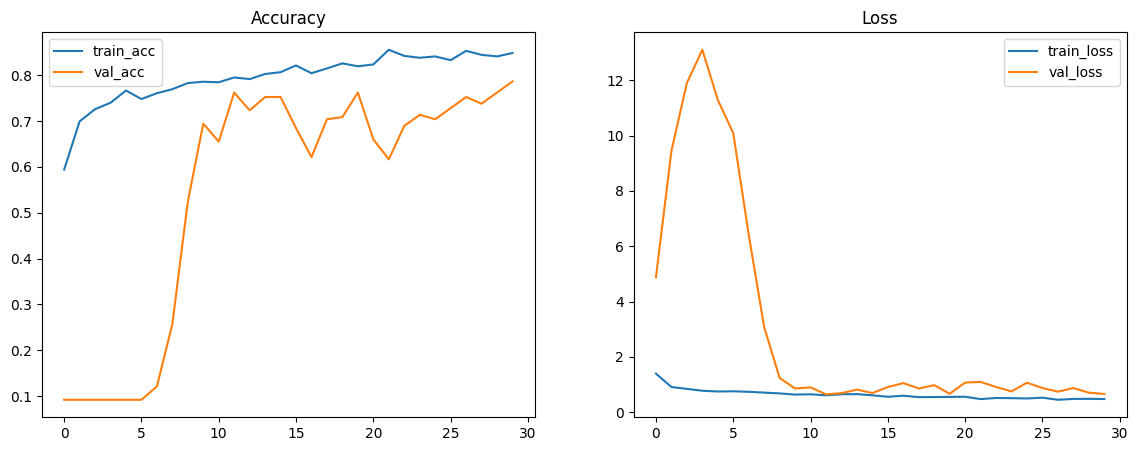

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()


In [15]:
model.save('/content/plant-disease-predictor/ai-service/ai-model/Model/cnn_model.keras')

**Model Inference / Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


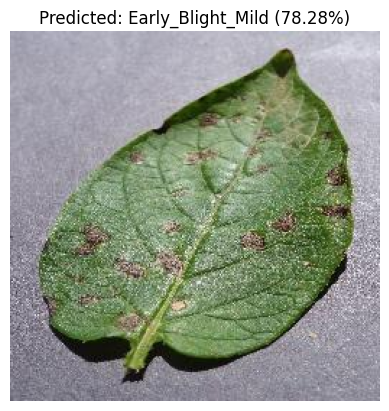

------------------------------------------------
Actual Class   : Early_Blight_Mild
Predicted Class: Early_Blight_Mild
Confidence     : 78.28%
------------------------------------------------


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# --- Load trained model ---
model_path = '/content/plant-disease-predictor/ai-service/ai-model/Model/final_cnn_model.keras'
model = load_model(model_path)

# --- Function to predict a single image with actual class info ---
def predict_image(image_path, class_names=class_names, image_size=224):
    # Extract actual class from folder name
    actual_class = os.path.basename(os.path.dirname(image_path))

    # Load image with OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to match model input
    img_resized = cv2.resize(img, (image_size, image_size))

    # Normalize pixel values (0-1)
    img_array = img_resized.astype('float32') / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = float(np.max(predictions)) * 100

    # Display image with predicted class
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    # Print formatted output
    print("------------------------------------------------")
    print(f"Actual Class   : {actual_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence     : {confidence:.2f}%")
    print("------------------------------------------------")

    return actual_class, predicted_class, confidence

# --- Example usage ---
example_image = '/content/plant-disease-predictor/ai-service/data/processed/Early_Blight_Mild/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG'
actual_class, predicted_class, confidence = predict_image(example_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


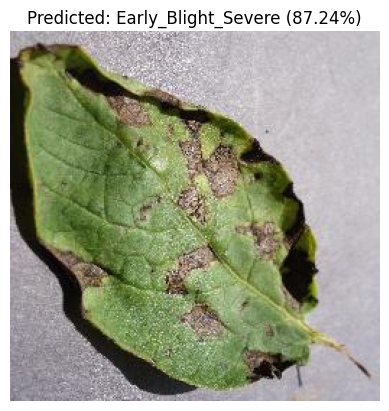

------------------------------------------------
Actual Class   : Early_Blight_Severe
Predicted Class: Early_Blight_Severe
Confidence     : 87.24%
------------------------------------------------


In [33]:
# 2--- Example usage ---
example_image = '/content/plant-disease-predictor/ai-service/data/processed/Early_Blight_Severe/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG'
actual_class, predicted_class, confidence = predict_image(example_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


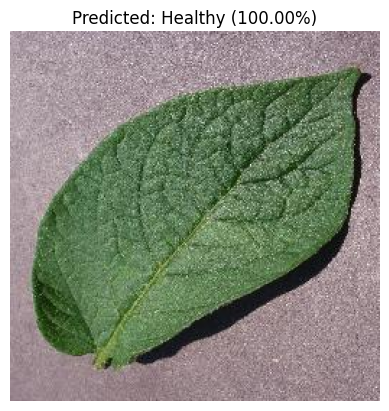

------------------------------------------------
Predicted Class: Healthy
Confidence     : 100.00%
------------------------------------------------


In [23]:
# --- Example usage ---
example_image = '/content/plant-disease-predictor/ai-service/data/processed/Healthy/04481ca2-f94c-457e-b785-1ac05800b7ec___RS_HL 1930.JPG'
actual_class, predicted_class, confidence = predict_image(example_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


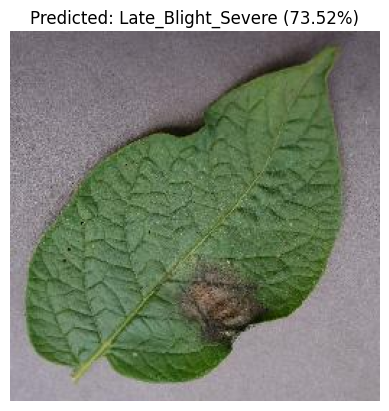

------------------------------------------------
Actual Class   : Late_Blight_Mild
Predicted Class: Late_Blight_Severe
Confidence     : 73.52%
------------------------------------------------


In [31]:
# 4 --- Example usage ---
example_image = '/content/plant-disease-predictor/ai-service/data/processed/Late_Blight_Mild/031c39d3-9a91-4e81-85ac-b36512133b0a___RS_LB 5220.JPG'
actual_class, predicted_class, confidence = predict_image(example_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


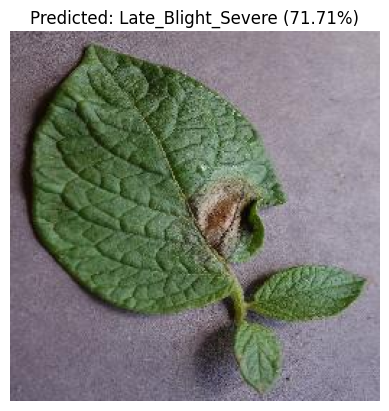

------------------------------------------------
Actual Class   : Late_Blight_Severe
Predicted Class: Late_Blight_Severe
Confidence     : 71.71%
------------------------------------------------


In [30]:
# 4 --- Example usage ---
example_image = '/content/plant-disease-predictor/ai-service/data/processed/Late_Blight_Severe/0085ef03-aec3-431a-99a1-de286e10c0cf___RS_LB 2949.JPG'
actual_class, predicted_class, confidence = predict_image(example_image)

In [ ]:
!git config --global user.name "Ramakrish21"
!git config --global user.email "adlaramakrishna28@gmail.com"


In [ ]:
!git add .

In [ ]:
!git commit -m "updated trained model"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
!git push origin main

Uploading LFS objects: 100% (1/1), 80 MB | 20 MB/s, done.
Enumerating objects: 12, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 2 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 142.52 MiB | 5.19 MiB/s, done.
Total 8 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File ai-service/ai-model/Model/best_cnn_model.keras is 76.75 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: File ai-service/ai-model/Model/final_cnn_model.keras is 76.75 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/Ramakrish21/plant-disease-predictor.git
   8df4517b..83c8518c  main -> main
